In [1]:
import joblib
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv("WineQT.csv")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [4]:
df = df.drop(["Id"], axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.shape

(1143, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [9]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1143
Variables: 12
cat_cols: 1
num_cols: 11
cat_but_car: 0
num_but_cat: 1


In [10]:
cat_cols

['quality']

In [11]:
num_cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [12]:
num_but_cat

['quality']

In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

   quality      Ratio
5      483  42.257218
6      462  40.419948
7      143  12.510936
4       33   2.887139
8       16   1.399825
3        6   0.524934
##########################################


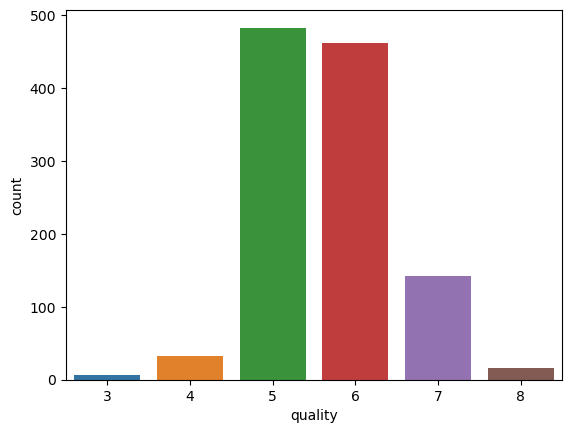

In [14]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [15]:
df['quality'] = np.where(df['quality'] <= 4, 0, np.where(df['quality'] <= 6, 1, 2))

   quality      Ratio
1      945  82.677165
2      159  13.910761
0       39   3.412073
##########################################


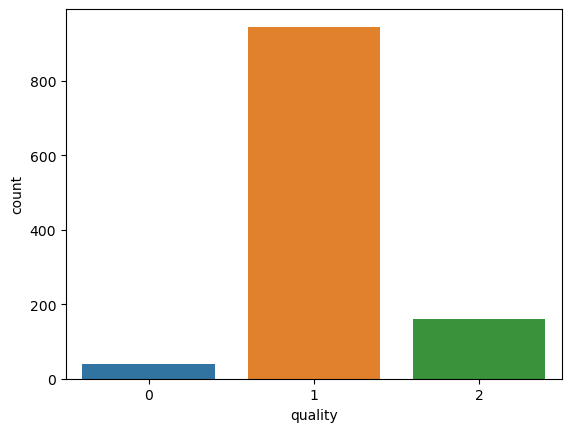

In [16]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

count    1143.000000
mean        8.311111
std         1.747595
min         4.600000
5%          6.100000
10%         6.500000
20%         7.000000
30%         7.300000
40%         7.600000
50%         7.900000
60%         8.300000
70%         8.900000
80%         9.600000
90%        10.700000
95%        11.900000
99%        13.300000
max        15.900000
Name: fixed acidity, dtype: float64


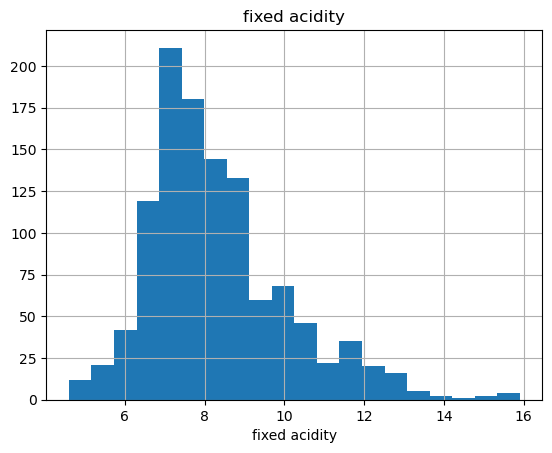

count    1143.000000
mean        0.531339
std         0.179633
min         0.120000
5%          0.271000
10%         0.310000
20%         0.370000
30%         0.420000
40%         0.475000
50%         0.520000
60%         0.575000
70%         0.615000
80%         0.670000
90%         0.750000
95%         0.840000
99%         1.020000
max         1.580000
Name: volatile acidity, dtype: float64


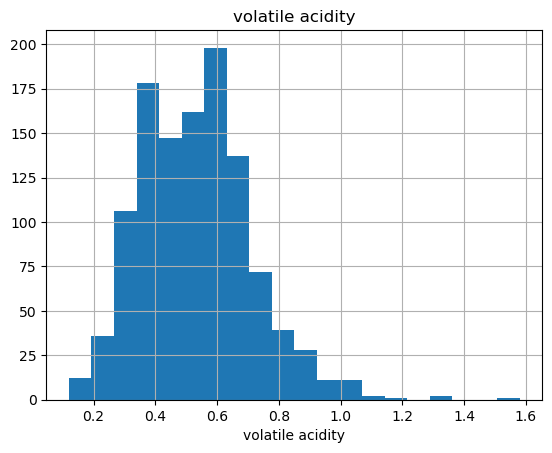

count    1143.000000
mean        0.268364
std         0.196686
min         0.000000
5%          0.000000
10%         0.010000
20%         0.060000
30%         0.120000
40%         0.210000
50%         0.250000
60%         0.310000
70%         0.390000
80%         0.460000
90%         0.530000
95%         0.619000
99%         0.730000
max         1.000000
Name: citric acid, dtype: float64


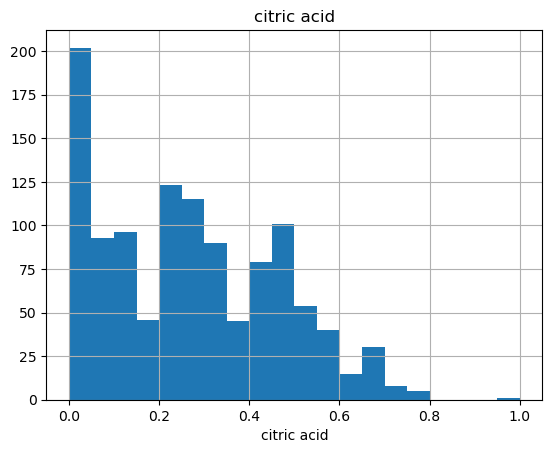

count    1143.000000
mean        2.532152
std         1.355917
min         0.900000
5%          1.600000
10%         1.700000
20%         1.800000
30%         2.000000
40%         2.100000
50%         2.200000
60%         2.300000
70%         2.500000
80%         2.700000
90%         3.600000
95%         5.195000
99%         8.216000
max        15.500000
Name: residual sugar, dtype: float64


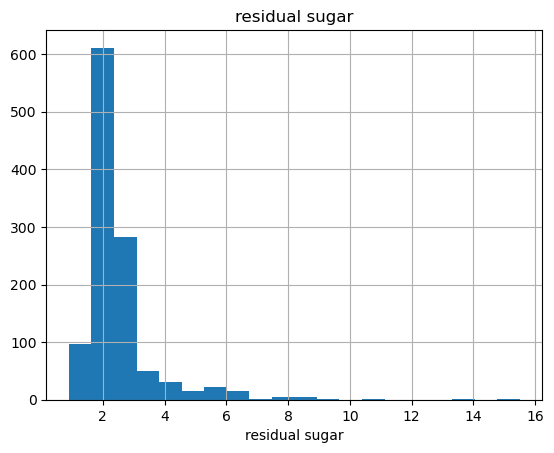

count    1143.000000
mean        0.086933
std         0.047267
min         0.012000
5%          0.054000
10%         0.060000
20%         0.067000
30%         0.072000
40%         0.076000
50%         0.079000
60%         0.082000
70%         0.087000
80%         0.094000
90%         0.107000
95%         0.123000
99%         0.350860
max         0.611000
Name: chlorides, dtype: float64


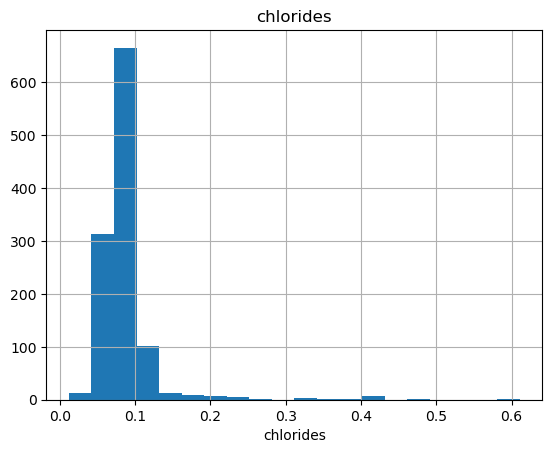

count    1143.000000
mean       15.615486
std        10.250486
min         1.000000
5%          4.000000
10%         5.000000
20%         6.000000
30%         9.000000
40%        11.000000
50%        13.000000
60%        16.000000
70%        19.000000
80%        24.000000
90%        30.800000
95%        35.000000
99%        48.000000
max        68.000000
Name: free sulfur dioxide, dtype: float64


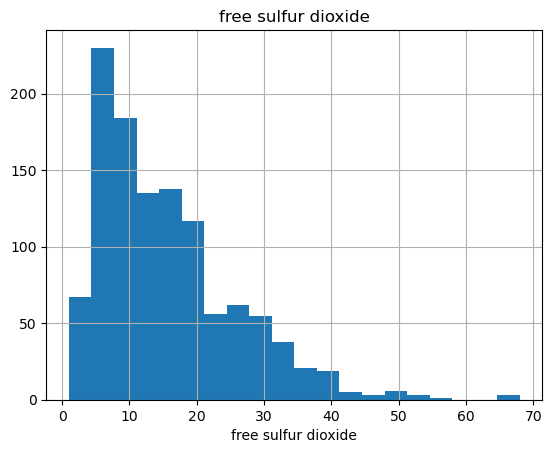

count    1143.000000
mean       45.914698
std        32.782130
min         6.000000
5%         12.000000
10%        14.000000
20%        19.000000
30%        24.000000
40%        29.000000
50%        37.000000
60%        45.000000
70%        54.000000
80%        68.000000
90%        91.000000
95%       112.000000
99%       143.000000
max       289.000000
Name: total sulfur dioxide, dtype: float64


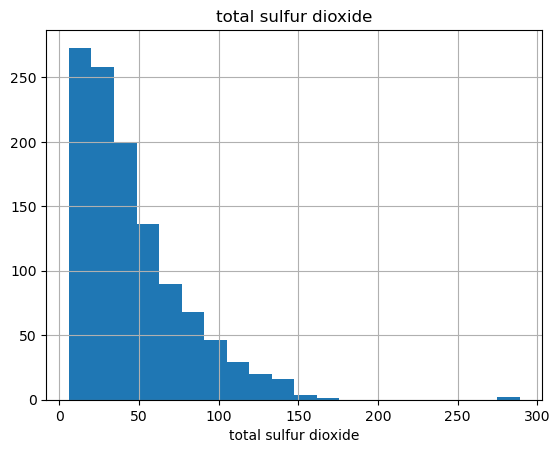

count    1143.000000
mean        0.996730
std         0.001925
min         0.990070
5%          0.993602
10%         0.994564
20%         0.995280
30%         0.995800
40%         0.996266
50%         0.996680
60%         0.997122
70%         0.997600
80%         0.998200
90%         0.999188
95%         1.000000
99%         1.002100
max         1.003690
Name: density, dtype: float64


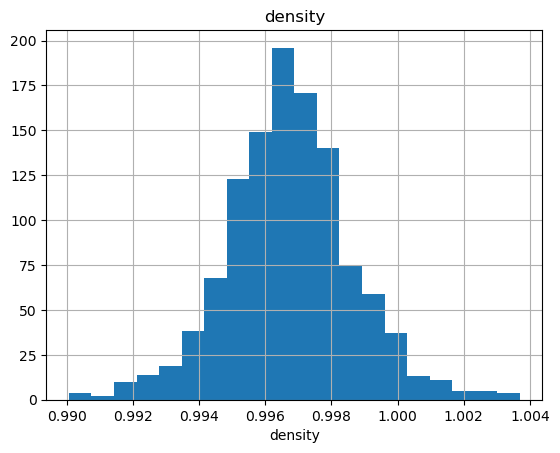

count    1143.000000
mean        3.311015
std         0.156664
min         2.740000
5%          3.070000
10%         3.120000
20%         3.180000
30%         3.230000
40%         3.270000
50%         3.310000
60%         3.350000
70%         3.380000
80%         3.430000
90%         3.510000
95%         3.570000
99%         3.695800
max         4.010000
Name: pH, dtype: float64


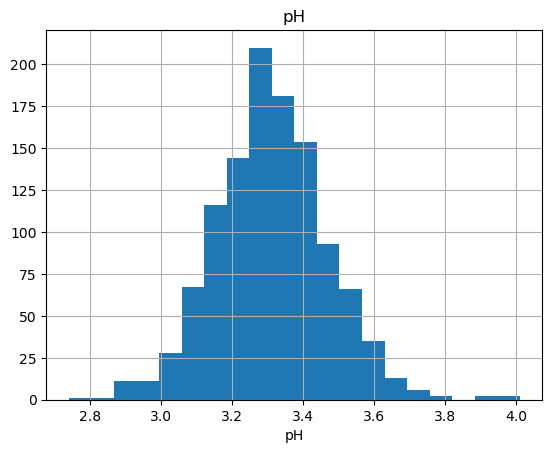

count    1143.000000
mean        0.657708
std         0.170399
min         0.330000
5%          0.470000
10%         0.500000
20%         0.540000
30%         0.560000
40%         0.590000
50%         0.620000
60%         0.650000
70%         0.700000
80%         0.760000
90%         0.850000
95%         0.930000
99%         1.243200
max         2.000000
Name: sulphates, dtype: float64


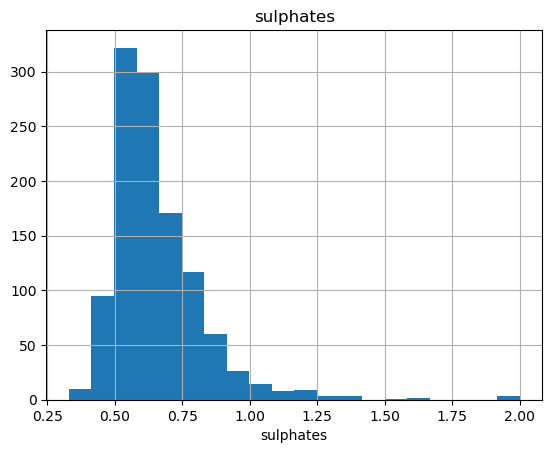

count    1143.000000
mean       10.442111
std         1.082196
min         8.400000
5%          9.200000
10%         9.300000
20%         9.500000
30%         9.600000
40%         9.900000
50%        10.200000
60%        10.500000
70%        10.900000
80%        11.400000
90%        12.000000
95%        12.500000
99%        13.496667
max        14.900000
Name: alcohol, dtype: float64


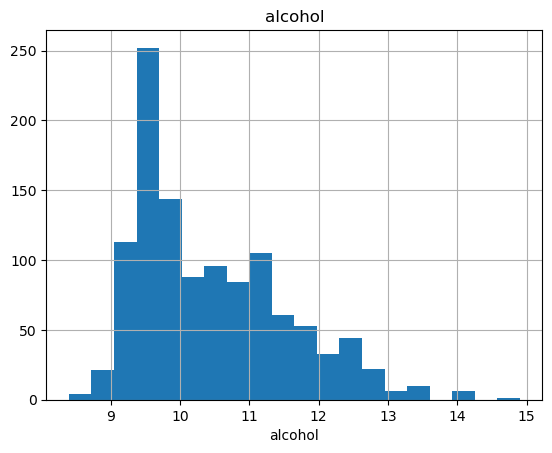

In [17]:
for col in num_cols:
    num_summary(df, col, plot=True)

         fixed acidity_mean
quality                    
0                  7.907692
1                  8.237672
2                  8.846541




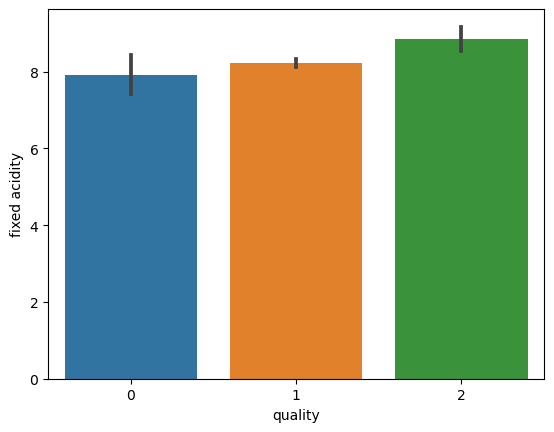

         volatile acidity_mean
quality                       
0                     0.730385
1                     0.546011
2                     0.395314




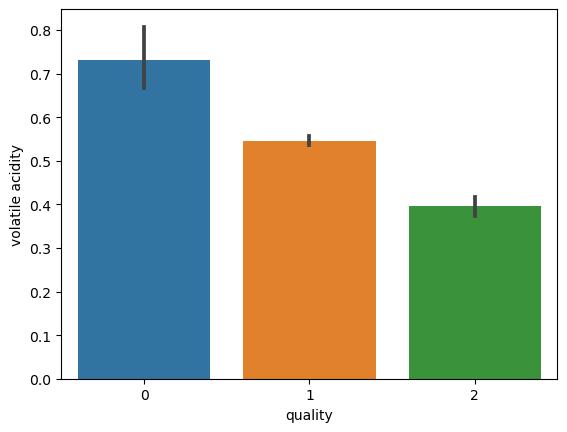

         citric acid_mean
quality                  
0                0.172821
1                0.251640
2                0.391195




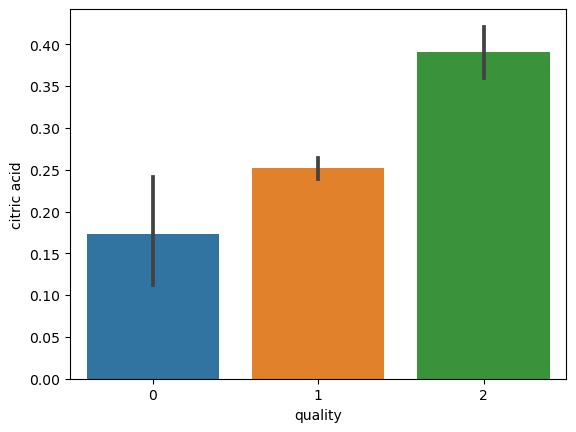

         residual sugar_mean
quality                     
0                   2.582051
1                   2.493704
2                   2.748428




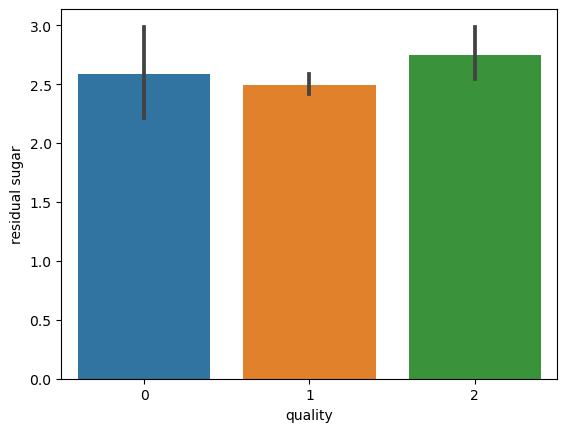

         chlorides_mean
quality                
0              0.096410
1              0.088598
2              0.074711




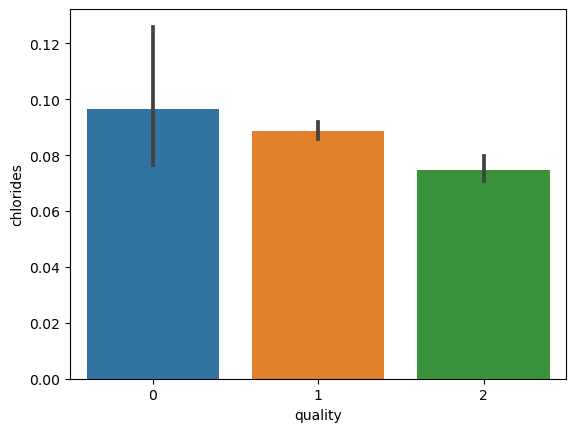

         free sulfur dioxide_mean
quality                          
0                       13.820513
1                       15.929630
2                       14.188679




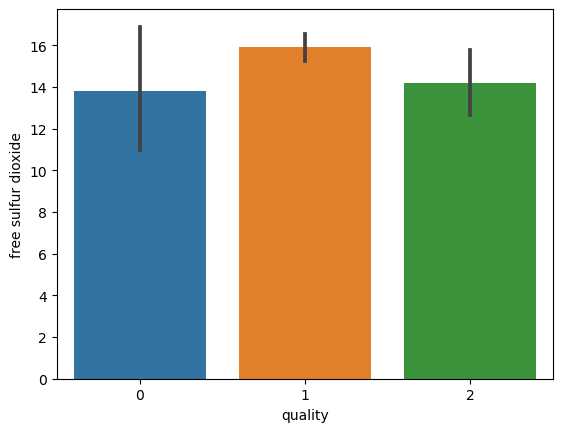

         total sulfur dioxide_mean
quality                           
0                        38.128205
1                        47.791005
2                        36.672956




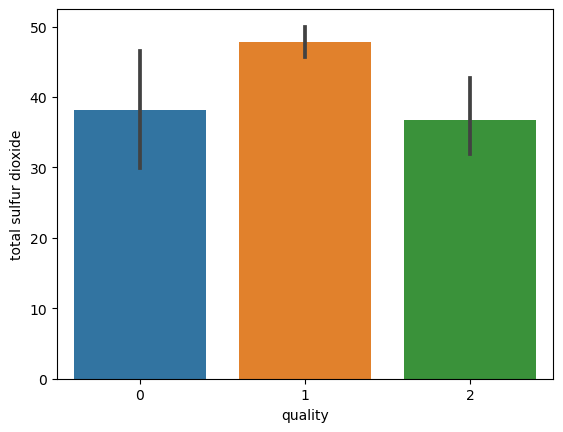

         density_mean
quality              
0            0.996825
1            0.996846
2            0.996019




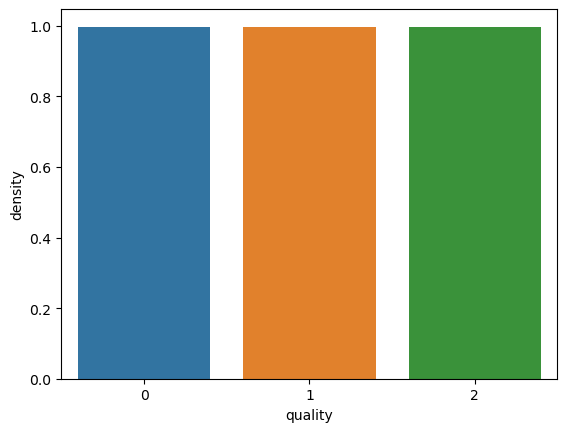

          pH_mean
quality          
0        3.386667
1        3.312698
2        3.282453




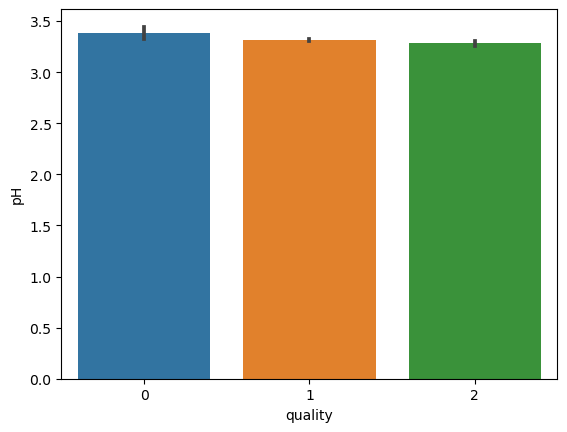

         sulphates_mean
quality                
0              0.624359
1              0.644254
2              0.745849




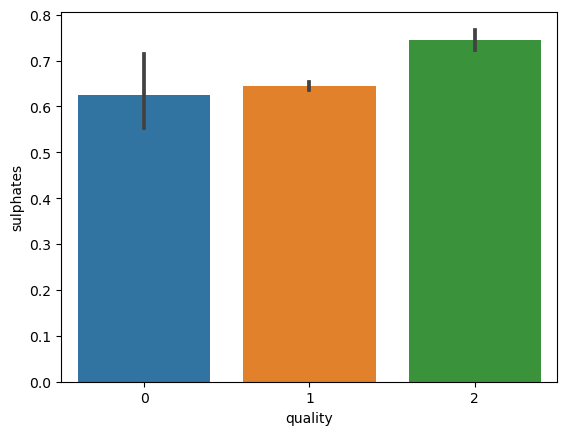

         alcohol_mean
quality              
0           10.173077
1           10.270441
2           11.528407




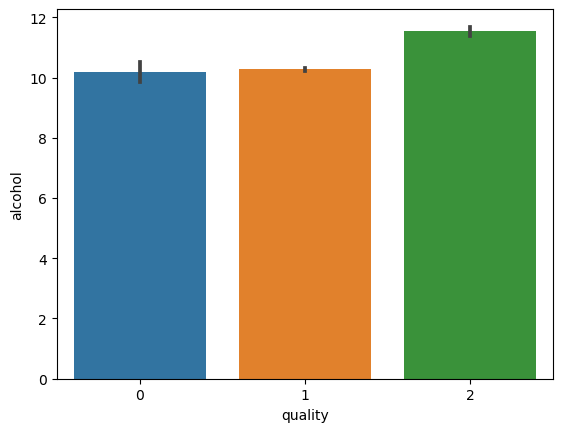

In [18]:
for col in num_cols:
    target_summary_with_num(df, 'quality', col, plot=True)

In [19]:
def df_corr(dataframe, annot=False):
    sns.heatmap(dataframe.corr(), annot=annot, linewidths=.2, cmap='Reds', square=True)
    plt.show(block=True)

def high_correlated_cols(dataframe,head=10):
    corr_matrix = dataframe.corr().abs()
    corr_cols = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                                   .astype(bool)).stack().sort_values(ascending=False)).head(head)
    return corr_cols

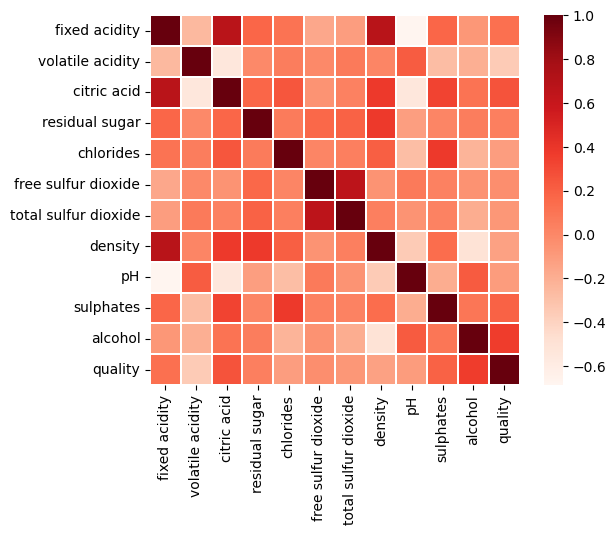

In [20]:
df_corr(df)

In [21]:
high_correlated_cols(df)

fixed acidity        pH                      0.685163
                     density                 0.681501
                     citric acid             0.673157
free sulfur dioxide  total sulfur dioxide    0.661093
citric acid          pH                      0.546339
volatile acidity     citric acid             0.544187
density              alcohol                 0.494727
residual sugar       density                 0.380147
citric acid          density                 0.375243
chlorides            sulphates               0.374784
dtype: float64

In [22]:
def outlier_thresholds(dataframe, col_name, q1=.05, q3=.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=.05, q3=.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def boxplot_outliers(dataframe, col_name):
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=dataframe[col_name])
    plt.show(block=True)

def replace_with_thresholds(dataframe, col_name, q1=.05, q3=.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])
    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [23]:
for col in num_cols:
    print(col, ':', check_outlier(df, col))

fixed acidity : False
volatile acidity : False
citric acid : False
residual sugar : True
chlorides : True
free sulfur dioxide : False
total sulfur dioxide : True
density : False
pH : False
sulphates : True
alcohol : False


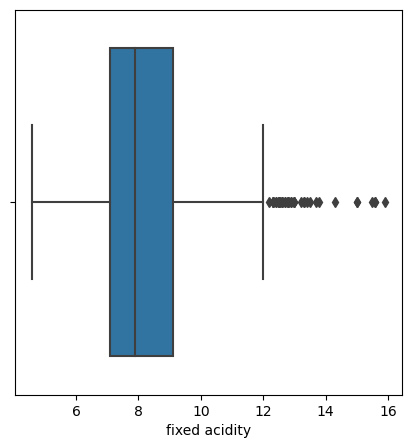

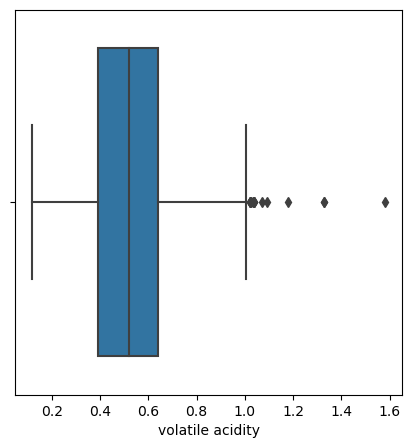

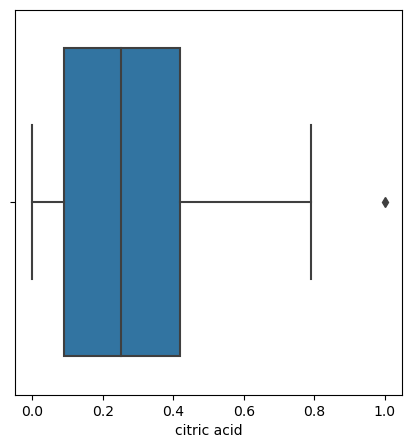

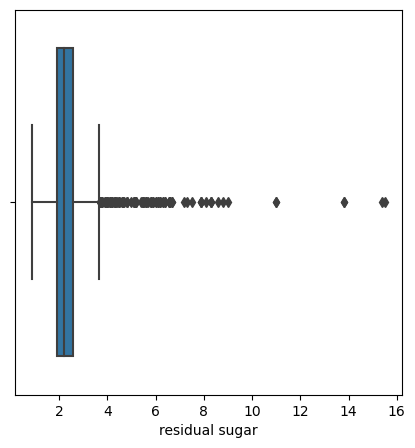

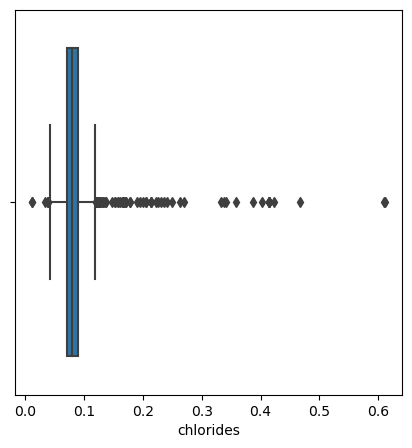

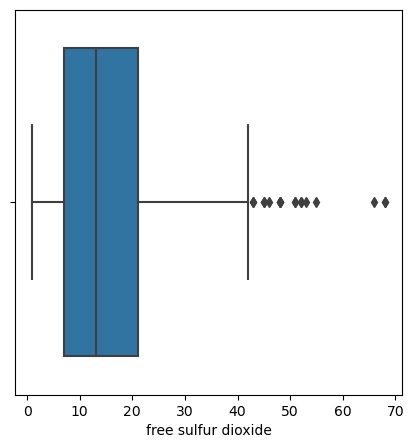

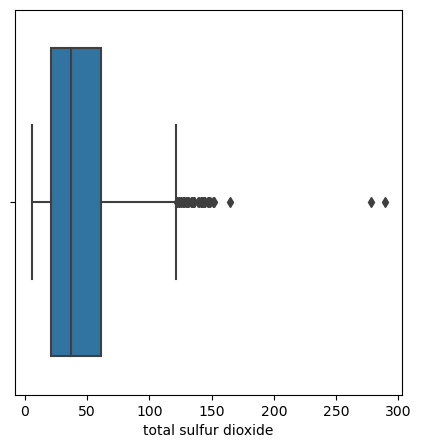

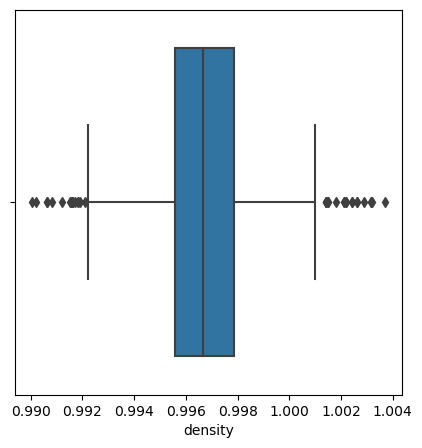

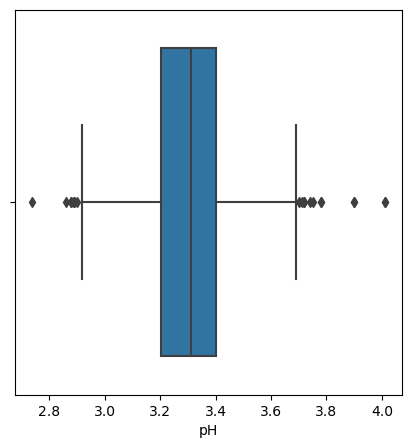

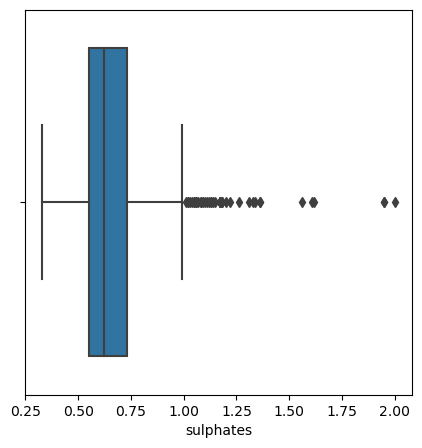

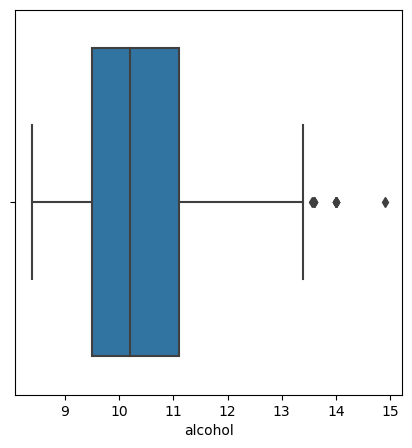

In [24]:
for col in num_cols:
    boxplot_outliers(df, col)

In [25]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [26]:
for col in num_cols:
    print(col, ':', check_outlier(df, col))

fixed acidity : False
volatile acidity : False
citric acid : False
residual sugar : False
chlorides : False
free sulfur dioxide : False
total sulfur dioxide : False
density : False
pH : False
sulphates : False
alcohol : False


In [27]:
df['acidity_ratio'] = df['fixed acidity'] / df['volatile acidity']
df['free_sulfur/total_sulfur'] = df['free sulfur dioxide'] / df['total sulfur dioxide']
df['sugar/alcohol'] = df['residual sugar'] / df['alcohol']
df['alcohol/density'] = df['alcohol'] / df['density']
df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
df['bound_sulfur'] = df['total sulfur dioxide'] - df['free sulfur dioxide']
df['alcohol/pH'] = df['alcohol'] / df['pH']
df['alcohol/acidity'] = df['alcohol'] / df['total_acid']
df['alkalinity'] = df['pH'] + df['alcohol']
df['mineral'] = df['chlorides'] + df['sulphates'] + df['residual sugar']
df['density/pH'] = df['density'] / df['pH']
df['total_alcohol'] = df['alcohol'] + df['residual sugar']
    
df['acid/density'] = df['total_acid']  / df['density']
df['sulphate/density'] = df['sulphates']  / df['density']
df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
df['sulphates*alcohol'] = df['sulphates'] * df['alcohol']

In [28]:
y = df["quality"]
X = df.drop(["quality"], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [30]:
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier(verbose= -100)),
                   ('CatBoost', CatBoostClassifier(verbose=False))]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")


In [31]:
base_models(X_train, y_train)

Base Models....
accuracy: 0.8325 (LR) 
accuracy: 0.8138 (KNN) 
accuracy: 0.82 (SVC) 
accuracy: 0.795 (CART) 
accuracy: 0.8612 (RF) 
accuracy: 0.6862 (Adaboost) 
accuracy: 0.8425 (GBM) 
accuracy: 0.8538 (XGBoost) 
accuracy: 0.85 (LightGBM) 
accuracy: 0.8413 (CatBoost) 


In [32]:
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "sqrt"],
             "min_samples_split": [2, 5, 15],
             "n_estimators": [50, 100, 200]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

classifiers = [("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(eval_metric='logloss'), xgboost_params)]
        
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models


def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('RF', best_models["RF"]),
                                              ('XGBoost', best_models["XGBoost"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=["accuracy"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    return voting_clf

In [33]:
best_models = hyperparameter_optimization(X_train, y_train)

Hyperparameter Optimization....
########## RF ##########
accuracy (Before): 0.855
accuracy (After): 0.8588
RF best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 200}

########## XGBoost ##########
accuracy (Before): 0.8538
accuracy (After): 0.855
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}



In [34]:
voting_clf = voting_classifier(best_models, X_train, y_train)

Voting Classifier...
Accuracy: 0.85625


In [35]:
y_pred_best = voting_clf.predict(X_test)
print("\nTest Set Classification Report (Best Model):\n", classification_report(y_test, y_pred_best))


Test Set Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.91      0.97      0.93       289
           2       0.74      0.56      0.63        45

    accuracy                           0.89       343
   macro avg       0.55      0.51      0.52       343
weighted avg       0.86      0.89      0.87       343



In [36]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['acidity_ratio'] = X['fixed acidity'] / X['volatile acidity']
        X['free_sulfur/total_sulfur'] = X['free sulfur dioxide'] / X['total sulfur dioxide']
        X['sugar/alcohol'] = X['residual sugar'] / X['alcohol']
        X['alcohol/density'] = X['alcohol'] / X['density']
        X['total_acid'] = X['fixed acidity'] + X['volatile acidity'] + X['citric acid']
        X['sulphates/chlorides'] = X['sulphates'] / X['chlorides']
        X['bound_sulfur'] = X['total sulfur dioxide'] - X['free sulfur dioxide']
        X['alcohol/pH'] = X['alcohol'] / X['pH']
        X['alcohol/acidity'] = X['alcohol'] / X['total_acid']
        X['alkalinity'] = X['pH'] + X['alcohol']
        X['mineral'] = X['chlorides'] + X['sulphates'] + X['residual sugar']
        X['density/pH'] = X['density'] / X['pH']
        X['total_alcohol'] = X['alcohol'] + X['residual sugar']
        X['acid/density'] = X['total_acid'] / X['density']
        X['sulphate/density'] = X['sulphates'] / X['density']
        X['sulphates/acid'] = X['sulphates'] / X['volatile acidity']
        X['sulphates*alcohol'] = X['sulphates'] * X['alcohol']
        return X
  
rf = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=2, n_estimators=200)
xgb = XGBClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=200)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
    ('voting_clf', voting_clf)
])


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8862973760932945


In [38]:
pipeline

Pipeline(steps=[('feature_adder', FeatureAdder()),
                ('voting_clf',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(max_depth=15,
                                                                      n_estimators=200)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.5,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             ev...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.01,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))],
                                  voting='soft'))])

In [39]:
joblib.dump(pipeline, "wine_quality.joblib")

['wine_quality.joblib']

In [40]:
def get_pipeline():
    pipeline = joblib.load("wine_quality.joblib")
    return pipeline

In [41]:
pipeline = get_pipeline()

In [42]:
data = {
    'fixed acidity': [10.7],
    'volatile acidity': [0.35],
    'citric acid': [0.53],
    'residual sugar': [2.6],
    'chlorides': [0.07],
    'free sulfur dioxide': [5.0],
    'total sulfur dioxide': [16.0],
    'density': [0.9972],
    'pH': [3.15],
    'sulphates': [0.65],
    'alcohol': [11.0]
}

sample_df = pd.DataFrame(data)

In [43]:
pipeline.predict(sample_df)

array([2])

In [44]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
rfc_acc = accuracy_score(y_test, rfc_pred)
print('RandomForestClassifier accuracy:', rfc_acc)

RandomForestClassifier accuracy: 0.8717201166180758


In [45]:
def plot_importance(model, features, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False)[0:len(X)])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

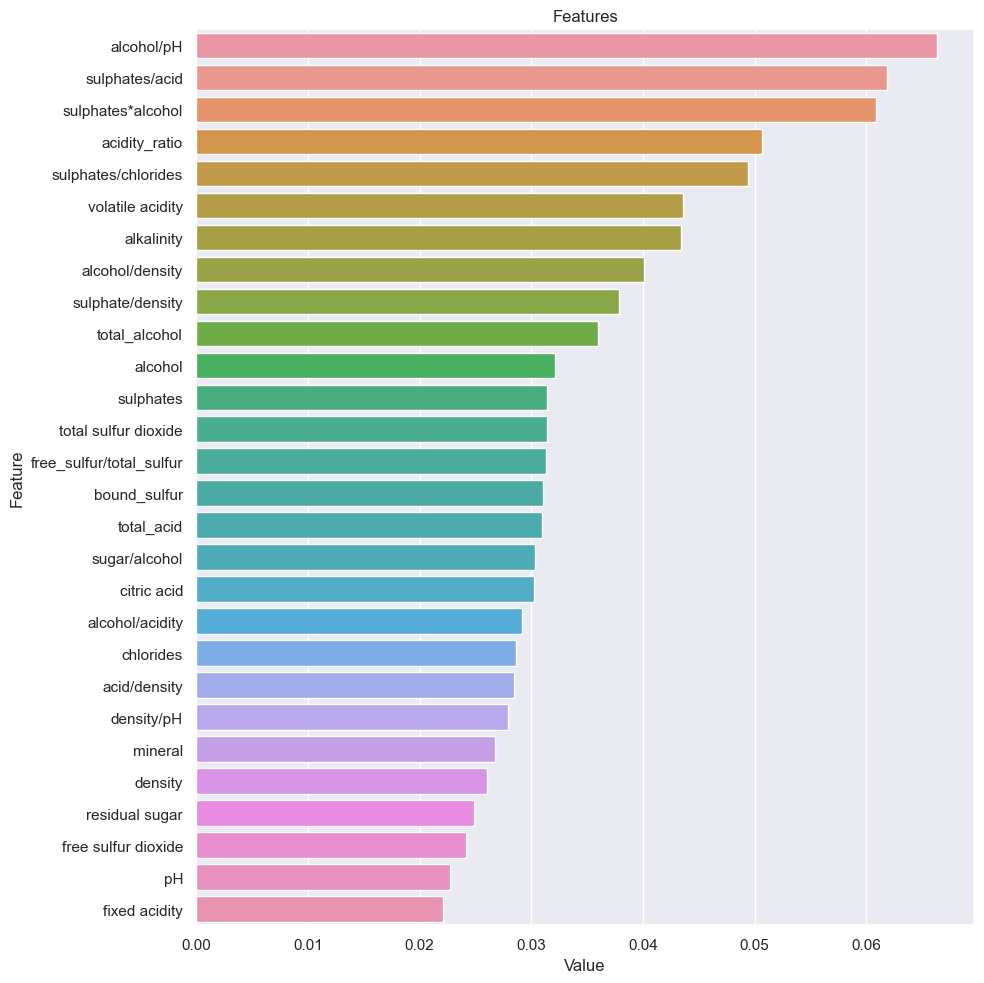

In [46]:
plot_importance(rfc, X_train)

In [47]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
gbc_acc = accuracy_score(y_test, gbc_pred)
print('GradientBoostingClassifier accuracy:', gbc_acc)

GradientBoostingClassifier accuracy: 0.8775510204081632


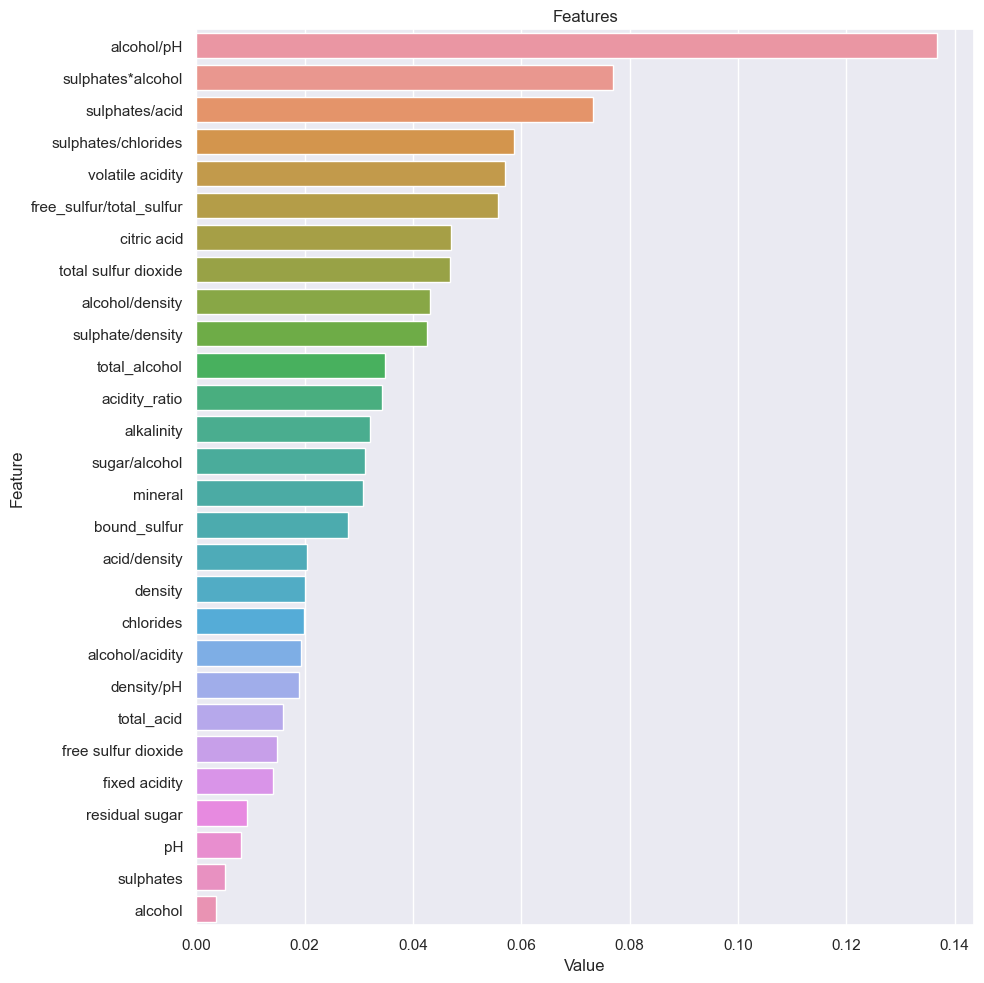

In [48]:
plot_importance(gbc, X_train)